In [4]:
%ls

0_a_k.gro  0_w_k.gro  1_a_k.trr  1_w_k.gro*   notebook.ipynb
0_a_n.gro  0_w_n.gro  1_a_n.gro  1_w_n.gro    pmf.pdf
0_a_n.trr  1_a_k.gro  1_a_n.trr  1_xtal.gro*


0_a_k -5.4398892641684355
0_a_n -5.335613151291733
0_w_k 4.019381523748645
0_w_n 1.9831815438525453
1_a_k -3.6258213181467998
1_a_n -5.184588601219693
1_w_k 3.423670237514214
1_w_n 2.7551969795279123


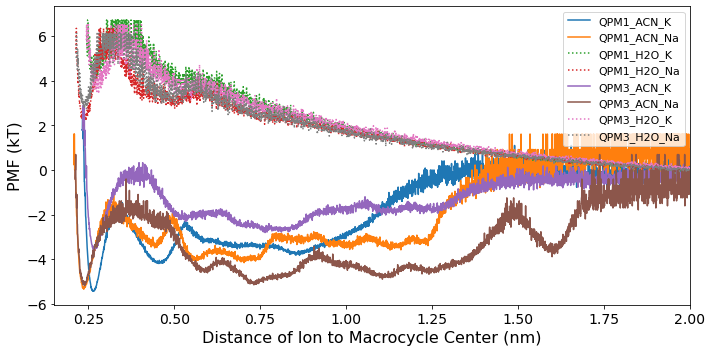

In [9]:
import mdtraj as md
import itertools, math
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import cm
from pandas.plotting import autocorrelation_plot
import numpy as np
import tqdm
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

hfont = {'fontname':'Helvetica'}
names = ['QPM1_ACN_K','QPM1_ACN_Na','QPM1_H2O_K','QPM1_H2O_Na','QPM3_ACN_K','QPM3_ACN_Na','QPM3_H2O_K','QPM3_H2O_Na']
kB = 1.38064852*10**-23
T = 300
R = 6.022*10**23
ion_names = ['K','NA']
name_count = 0
bulk_cutoff = 2.0
for bins in [5000]:
    for macrocycle in ['0','1']:
        for solvent in ['a','w']:
            for x,ion in enumerate(['k','n']):
                prefix = f'{macrocycle}_{solvent}_{ion}'
                traj = md.load(f'{prefix}.trr',top=f'{prefix}.gro')
                carbonyl_o_indices = [a.index for a in traj.topology.atoms if a.name == 'O'][:6]
                ion_indices = [a.index for a in traj.topology.atoms if a.name == ion_names[x]]
                pairs = itertools.product(carbonyl_o_indices, ion_indices)
                ion_O_distances = np.concatenate(md.compute_distances(traj, pairs))
                #avg_distances = [np.average(x) for x in md.compute_distances(traj, pairs)]
                counts, distances = np.histogram(ion_O_distances, bins)
                counts = [x+1 for x in counts]
                #pmf = [-kB*T*math.log(counts[i]) + kB*T*2*distances[i] for i in range(len(counts))]
                pmf = [-math.log(i) for i in counts]
                ndx = min(range(len(distances)), key=lambda i: abs(distances[i]-bulk_cutoff))

                pmf = [x - pmf[ndx] for x in pmf]
                plt.figure(2, figsize=(10,5))
                try:
                    if solvent == 'w':
                        plt.plot(distances[1:],pmf,label=names[name_count], linestyle='dotted')
                    else:
                        plt.plot(distances[1:],pmf,label=names[name_count])
                except Exception as e:
                    continue
                idx = (np.abs(distances - 0.35)).argmin()
                print(prefix, min(pmf[:idx]))
                name_count += 1

    plt.xlim(0.15,2.0)
    plt.ylabel('PMF (kT)',fontsize=16, **hfont)
    plt.xlabel('Distance of Ion to Macrocycle Center (nm)',fontsize=16, **hfont)
    plt.xticks(fontsize=14, rotation=0)
    plt.yticks(fontsize=14, rotation=0)
    #plt.title('PMFs Comparing Solvent, Cation, and Macrocycle Substituents')
    plt.legend(loc='upper right',prop={'size': 11})
    plt.tight_layout()
    plt.show()
    plt.savefig(f'pmf_{bins}.pdf')
    plt.close()

In [23]:
import mdtraj as md
import itertools, math
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import cm
from pandas.plotting import autocorrelation_plot
import numpy as np
import tqdm
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

hfont = {'fontname':'Helvetica'}
names = ['QPM1_ACN_K','QPM1_ACN_Na','QPM1_H2O_K','QPM1_H2O_Na','QPM3_ACN_K','QPM3_ACN_Na','QPM3_H2O_K','QPM3_H2O_Na']
kB = 1.38064852*10**-23
T = 300
R = 8.314
NA = 6.022*10**23
ion_names = ['K','NA']
name_count = 0
bulk_cutoff = 2.0
results = []
for macrocycle in ['0','1']:
    for solvent in ['a','w']:
        for x,ion in enumerate(['k','n']):
            g_bind, k_d = [],[]
            prefix = f'{macrocycle}_{solvent}_{ion}'
            traj = md.load(f'{prefix}.trr',top=f'{prefix}.gro')
            carbonyl_o_indices = [a.index for a in traj.topology.atoms if a.name == 'O'][:6]
            ion_indices = [a.index for a in traj.topology.atoms if a.name == ion_names[x]]
            pairs = itertools.product(carbonyl_o_indices, ion_indices)
            ion_O_distances = np.concatenate(md.compute_distances(traj, pairs))

            with open(f'{prefix}.gro') as f:
                box_vectors = [float(x) for x in f.readlines()[-1].split()]
            moles = 4 / NA
            volume = (box_vectors[0]*box_vectors[1]*box_vectors[2]) / (10**24) # L
            concentration = moles/volume

            for i in range(100):
                bootstrap_distances = np.random.choice(ion_O_distances, replace=True, size=len(ion_O_distances))
                counts, distances = np.histogram(bootstrap_distances, bins)
                counts = [x+1 for x in counts]
                pmf = [-math.log(i) for i in counts]
                #pmf = [-math.log(i) + math.log(concentration) for i in counts]
                #print('correction: ',math.log(concentration))
                ndx = min(range(len(distances)), key=lambda i: abs(distances[i]-bulk_cutoff))
                pmf = [x - pmf[ndx] for x in pmf]
                idx = (np.abs(distances - 0.35)).argmin()
                g_bind.append(min(pmf[:idx]))
                k_d.append(math.exp(min(pmf[:idx])))
            #plt.hist(g_bind, bins=20)
            #plt.title(f'{prefix}: avg: {np.average(g_bind)}, std: {np.std(g_bind)}')
            #plt.show()
            #plt.close()

            del_g = np.average(g_bind) + math.log(concentration)
            k_d = np.average([math.exp(x + math.log(concentration)) for x in g_bind])
            g_std = np.std(g_bind)
            k_std = np.std([math.exp(x + math.log(concentration)) for x in g_bind])
            #results.append([prefix,np.average(g_bind)+math.log(concentration),np.std(g_bind),math.exp(np.average(g_bind)+math.log(concentration)),np.std(k_d)])
            results.append([prefix,del_g, g_std, k_d, k_std])
for i in results:
    print(i)

['0_a_k', -7.521660562143182, 0.24681877468782454, 0.00055725791021977, 0.00013218740834851874]
['0_a_n', -8.027274024062613, 0.5198711086470416, 0.0003706409168579916, 0.00018210390434582785]
['0_w_k', 1.8985280769338715, 0.134762850197858, 6.736084967328262, 0.8929107450389364]
['0_w_n', -0.1646080593886956, 0.06491175617420714, 0.8500013290835615, 0.05459683258784177]
['1_a_k', -5.483808957104575, 0.18112949413325347, 0.004222409061188026, 0.0007726720445356166]
['1_a_n', -7.204615841533566, 0.3564650124800284, 0.0007901981501619459, 0.00027402916936568393]
['1_w_k', 1.2907259522798276, 0.10037202916080347, 3.653477496868486, 0.35845138674264876]
['1_w_n', 0.5198267891443429, 0.08610767520062092, 1.6878730059862335, 0.14170919205383992]
